In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_dim = 2
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
for p in transitions.parameters():
    p.requires_grad_(False)

params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/118 and on k = 1 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4600000218488276 and for +1: 0.5400000256486237
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 1 	 Current ELBO: -304.3457336425781
Saved samples to ./pics/mnist_epoch_0_K_2_N_2_amortize_True.png


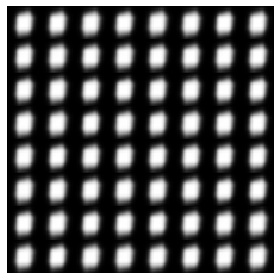

  0%|          | 1/1000 [00:27<7:30:17, 27.04s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4700000223238021 and for +1: 0.5300000251736492
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5240000248886645 and for +1: 0.4760000226087868
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 2 	 Current ELBO: -292.5496520996094
Saved samples to ./pics/mnist_epoch_1_K_2_N_2_amortize_True.png


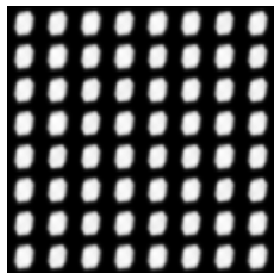

  0%|          | 2/1000 [00:53<7:29:21, 27.02s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.472000022418797 and for +1: 0.5280000250786543
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5100000242237002 and for +1: 0.49000002327375114
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 3 	 Current ELBO: -300.0772705078125
Saved samples to ./pics/mnist_epoch_2_K_2_N_2_amortize_True.png


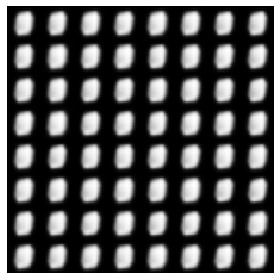

  0%|          | 3/1000 [01:21<7:30:13, 27.09s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5420000257436186 and for +1: 0.4580000217538327
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5240000248886645 and for +1: 0.4760000226087868
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.48200002289377153 and for +1: 0.5180000246036798
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.4780000227037817 and for +1: 0.5220000247936696
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 4 	 Current ELBO: -299.9842834472656
Saved samples to ./pics/mnist_epoch_3_K_2_N_2_amortize_True.png


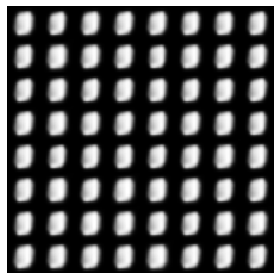

  0%|          | 4/1000 [01:51<7:43:28, 27.92s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5000000237487257 and for +1: 0.5000000237487257
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.51400002441369 and for +1: 0.48600002308376133
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5400000256486237 and for +1: 0.4600000218488276
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.49800002365373075 and for +1: 0.5020000238437206
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 5 	 Current ELBO: -294.4203186035156
Saved samples to ./pics/mnist_epoch_4_K_2_N_2_amortize_True.png


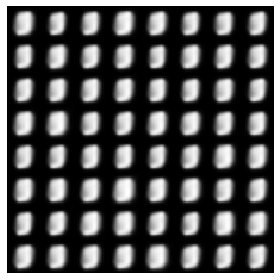

  0%|          | 5/1000 [02:17<7:37:40, 27.60s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4620000219438225 and for +1: 0.5380000255536288
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5280000250786543 and for +1: 0.472000022418797
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 6 	 Current ELBO: -293.5237731933594
Saved samples to ./pics/mnist_epoch_5_K_2_N_2_amortize_True.png


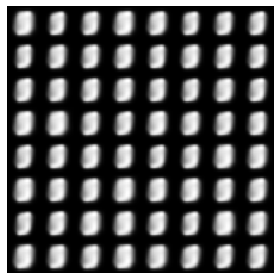

  1%|          | 6/1000 [02:44<7:33:27, 27.37s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5180000246036798 and for +1: 0.48200002289377153
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5520000262185931 and for +1: 0.4480000212788582
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 7 	 Current ELBO: -295.01611328125
Saved samples to ./pics/mnist_epoch_6_K_2_N_2_amortize_True.png


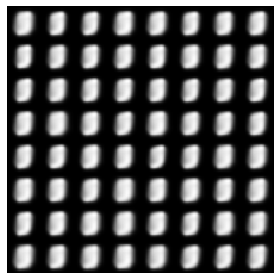

  1%|          | 7/1000 [03:11<7:30:21, 27.21s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4800000227987766 and for +1: 0.5200000246986747
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4780000227037817 and for +1: 0.5220000247936696
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.4600000218488276 and for +1: 0.5400000256486237
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 8 	 Current ELBO: -298.77264404296875
Saved samples to ./pics/mnist_epoch_7_K_2_N_2_amortize_True.png


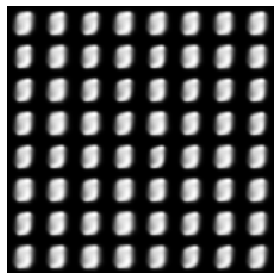

  1%|          | 8/1000 [03:38<7:28:02, 27.10s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4780000227037817 and for +1: 0.5220000247936696
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5060000240337104 and for +1: 0.49400002346374094
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5180000246036798 and for +1: 0.48200002289377153
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 9 	 Current ELBO: -293.9837646484375
Saved samples to ./pics/mnist_epoch_8_K_2_N_2_amortize_True.png


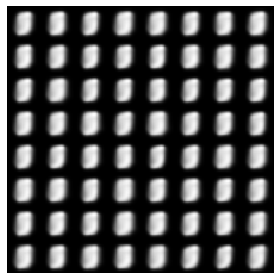

  1%|          | 9/1000 [04:05<7:26:18, 27.02s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4680000222288072 and for +1: 0.5320000252686441
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.48200002289377153 and for +1: 0.5180000246036798
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5120000243186951 and for +1: 0.48800002317875624
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5000000237487257 and for +1: 0.5000000237487257
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 10 	 Current ELBO: -303.3232727050781
Saved samples to ./pics/mnist_epoch_9_K_2_N_2_amortize_True.png


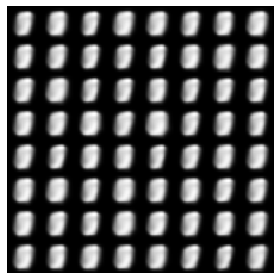

  1%|          | 10/1000 [04:32<7:24:58, 26.97s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5100000242237002 and for +1: 0.49000002327375114
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.472000022418797 and for +1: 0.5280000250786543
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.452000021468848 and for +1: 0.5480000260286033
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 11 	 Current ELBO: -291.8081970214844
Saved samples to ./pics/mnist_epoch_10_K_2_N_2_amortize_True.png


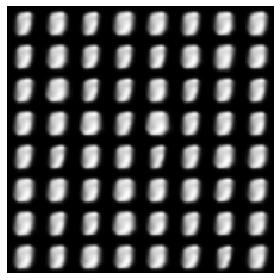

  1%|          | 11/1000 [04:59<7:24:04, 26.94s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5380000255536288 and for +1: 0.4620000219438225
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 12 	 Current ELBO: -300.21856689453125
Saved samples to ./pics/mnist_epoch_11_K_2_N_2_amortize_True.png


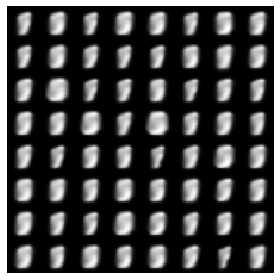

  1%|          | 12/1000 [05:25<7:23:06, 26.91s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.48800002317875624 and for +1: 0.5120000243186951
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49000002327375114 and for +1: 0.5100000242237002
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5220000247936696 and for +1: 0.4780000227037817
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 13 	 Current ELBO: -281.2141418457031
Saved samples to ./pics/mnist_epoch_12_K_2_N_2_amortize_True.png


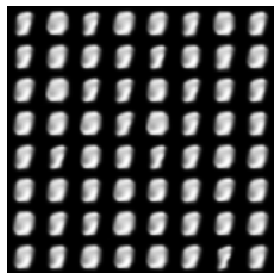

  1%|▏         | 13/1000 [05:52<7:22:19, 26.89s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5240000248886645 and for +1: 0.4760000226087868
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49000002327375114 and for +1: 0.5100000242237002
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5000000237487257 and for +1: 0.5000000237487257
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 14 	 Current ELBO: -288.9282531738281
Saved samples to ./pics/mnist_epoch_13_K_2_N_2_amortize_True.png


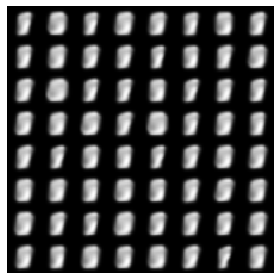

  1%|▏         | 14/1000 [06:21<7:29:33, 27.36s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.48400002298876643 and for +1: 0.5160000245086849
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4740000225137919 and for +1: 0.5260000249836594
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5120000243186951 and for +1: 0.48800002317875624
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 15 	 Current ELBO: -286.9119567871094
Saved samples to ./pics/mnist_epoch_14_K_2_N_2_amortize_True.png


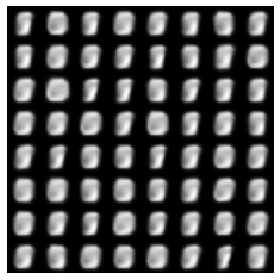

  2%|▏         | 15/1000 [06:49<7:34:40, 27.70s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5220000247936696 and for +1: 0.4780000227037817
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5260000249836594 and for +1: 0.4740000225137919
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 16 	 Current ELBO: -279.7574462890625
Saved samples to ./pics/mnist_epoch_15_K_2_N_2_amortize_True.png


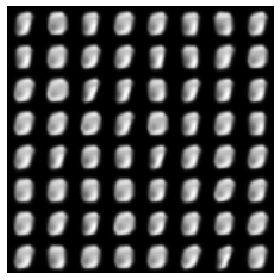

  2%|▏         | 16/1000 [07:16<7:30:00, 27.44s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5280000250786543 and for +1: 0.472000022418797
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4540000215638429 and for +1: 0.5460000259336084
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.4480000212788582 and for +1: 0.5520000262185931
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.472000022418797 and for +1: 0.5280000250786543
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 17 	 Current ELBO: -288.2563781738281
Saved samples to ./pics/mnist_epoch_16_K_2_N_2_amortize_True.png


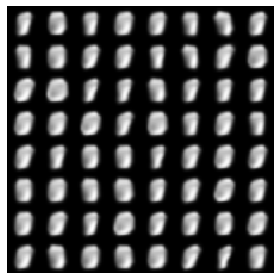

  2%|▏         | 17/1000 [07:43<7:26:42, 27.27s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5260000249836594 and for +1: 0.4740000225137919
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5100000242237002 and for +1: 0.49000002327375114
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.51400002441369 and for +1: 0.48600002308376133
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 18 	 Current ELBO: -281.32958984375
Saved samples to ./pics/mnist_epoch_17_K_2_N_2_amortize_True.png


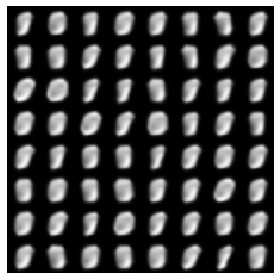

  2%|▏         | 18/1000 [08:10<7:24:10, 27.14s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5260000249836594 and for +1: 0.4740000225137919
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5200000246986747 and for +1: 0.4800000227987766
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5200000246986747 and for +1: 0.4800000227987766
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.49000002327375114 and for +1: 0.5100000242237002
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 19 	 Current ELBO: -275.7293395996094
Saved samples to ./pics/mnist_epoch_18_K_2_N_2_amortize_True.png


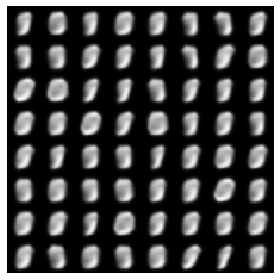

  2%|▏         | 19/1000 [08:37<7:22:16, 27.05s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5220000247936696 and for +1: 0.4780000227037817
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4800000227987766 and for +1: 0.5200000246986747
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.48400002298876643 and for +1: 0.5160000245086849
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.49000002327375114 and for +1: 0.5100000242237002
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 20 	 Current ELBO: -281.3385009765625
Saved samples to ./pics/mnist_epoch_19_K_2_N_2_amortize_True.png


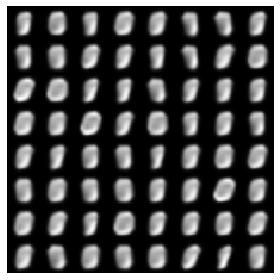

  2%|▏         | 20/1000 [09:04<7:21:49, 27.05s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.49800002365373075 and for +1: 0.5020000238437206
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.51400002441369 and for +1: 0.48600002308376133
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.4740000225137919 and for +1: 0.5260000249836594
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5380000255536288 and for +1: 0.4620000219438225
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 21 	 Current ELBO: -281.3232727050781
Saved samples to ./pics/mnist_epoch_20_K_2_N_2_amortize_True.png


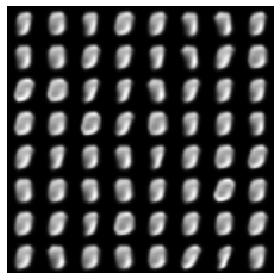

  2%|▏         | 21/1000 [09:33<7:33:58, 27.82s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.51400002441369 and for +1: 0.48600002308376133
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 22 	 Current ELBO: -287.0575866699219
Saved samples to ./pics/mnist_epoch_21_K_2_N_2_amortize_True.png


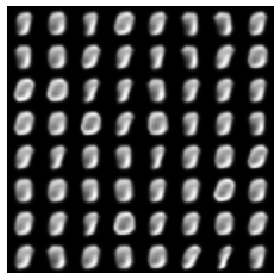

  2%|▏         | 22/1000 [10:03<7:42:00, 28.34s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5320000252686441 and for +1: 0.4680000222288072
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.48400002298876643 and for +1: 0.5160000245086849
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 23 	 Current ELBO: -286.442626953125
Saved samples to ./pics/mnist_epoch_22_K_2_N_2_amortize_True.png


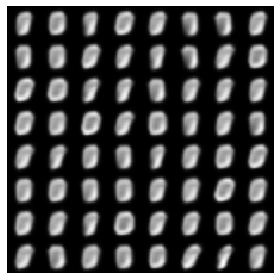

  2%|▏         | 23/1000 [10:33<7:49:06, 28.81s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.43600002070888877 and for +1: 0.5640000267885625
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5080000241287053 and for +1: 0.49200002336874604
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 24 	 Current ELBO: -269.1937255859375
Saved samples to ./pics/mnist_epoch_23_K_2_N_2_amortize_True.png


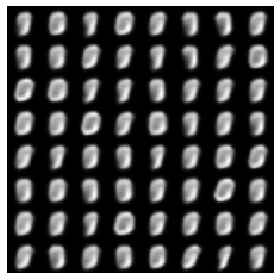

  2%|▏         | 24/1000 [11:03<7:53:58, 29.14s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4660000221338123 and for +1: 0.534000025363639
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4760000226087868 and for +1: 0.5240000248886645
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5160000245086849 and for +1: 0.48400002298876643
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 25 	 Current ELBO: -282.17950439453125
Saved samples to ./pics/mnist_epoch_24_K_2_N_2_amortize_True.png


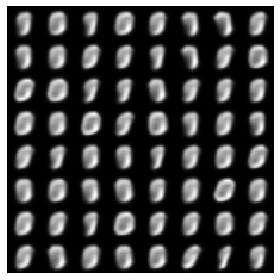

  2%|▎         | 25/1000 [11:33<7:57:25, 29.38s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.49600002355873585 and for +1: 0.5040000239387155
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5160000245086849 and for +1: 0.48400002298876643
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.48400002298876643 and for +1: 0.5160000245086849
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 26 	 Current ELBO: -279.0150146484375
Saved samples to ./pics/mnist_epoch_25_K_2_N_2_amortize_True.png


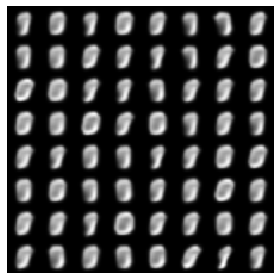

  3%|▎         | 26/1000 [12:02<7:59:29, 29.54s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.48600002308376133 and for +1: 0.51400002441369
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4780000227037817 and for +1: 0.5220000247936696
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5060000240337104 and for +1: 0.49400002346374094
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 27 	 Current ELBO: -283.73675537109375
Saved samples to ./pics/mnist_epoch_26_K_2_N_2_amortize_True.png


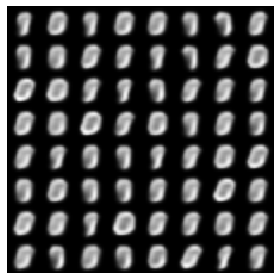

  3%|▎         | 27/1000 [12:32<7:58:53, 29.53s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.5240000248886645 and for +1: 0.4760000226087868
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4700000223238021 and for +1: 0.5300000251736492
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.5440000258386135 and for +1: 0.4560000216588378
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5020000238437206 and for +1: 0.49800002365373075
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 28 	 Current ELBO: -300.6050720214844
Saved samples to ./pics/mnist_epoch_27_K_2_N_2_amortize_True.png


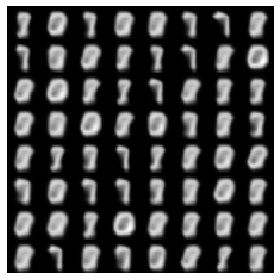

  3%|▎         | 28/1000 [12:59<7:45:19, 28.72s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4500000213738531 and for +1: 0.5500000261235982
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.48200002289377153 and for +1: 0.5180000246036798
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.27400001301430166 and for +1: 0.7260000344831496
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.6200000294484198 and for +1: 0.3800000180490315
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 29 	 Current ELBO: -304.8885803222656
Saved samples to ./pics/mnist_epoch_28_K_2_N_2_amortize_True.png


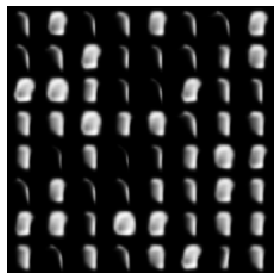

  3%|▎         | 29/1000 [13:26<7:35:42, 28.16s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.20600000978447497 and for +1: 0.7940000377129763
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.6400000303983688 and for +1: 0.36000001709908247
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.28000001329928637 and for +1: 0.7200000341981649
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.6800000322982669 and for +1: 0.3200000151991844
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 30 	 Current ELBO: -684.3529052734375
Saved samples to ./pics/mnist_epoch_29_K_2_N_2_amortize_True.png


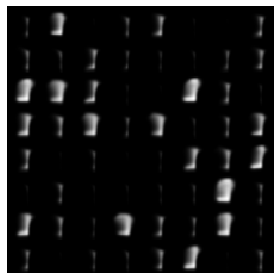

  3%|▎         | 30/1000 [13:52<7:28:48, 27.76s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.2380000113043934 and for +1: 0.7620000361930579
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.7620000361930579 and for +1: 0.2380000113043934
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.3040000144392252 and for +1: 0.6960000330582261
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5460000259336084 and for +1: 0.4540000215638429
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 31 	 Current ELBO: -1019.742431640625
Saved samples to ./pics/mnist_epoch_30_K_2_N_2_amortize_True.png


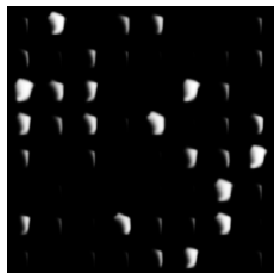

  3%|▎         | 31/1000 [14:19<7:23:51, 27.48s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.27200001291930676 and for +1: 0.7280000345781446
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.4460000211838633 and for +1: 0.554000026313588
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 0.26800001272931695 and for +1: 0.7320000347681344
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 0.5060000240337104 and for +1: 0.49400002346374094
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 32 	 Current ELBO: -767.2766723632812
Saved samples to ./pics/mnist_epoch_31_K_2_N_2_amortize_True.png


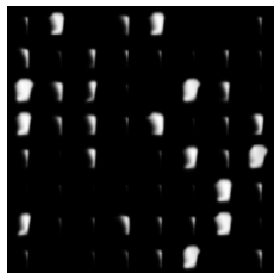

  3%|▎         | 32/1000 [14:46<7:20:15, 27.29s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.3120000148192048 and for +1: 0.6880000326782465
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 0.41600001975893974 and for +1: 0.5840000277385116
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 33 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_32_K_2_N_2_amortize_True.png


/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=Fa

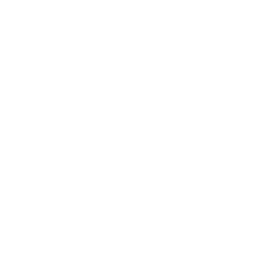

  3%|▎         | 33/1000 [15:13<7:17:36, 27.15s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 34 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_33_K_2_N_2_amortize_True.png


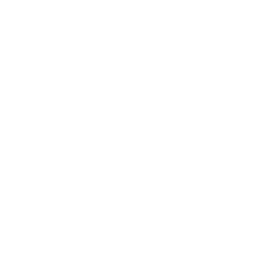

  3%|▎         | 34/1000 [15:40<7:15:35, 27.06s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 35 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_34_K_2_N_2_amortize_True.png


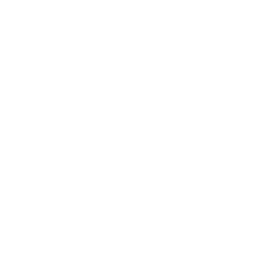

  4%|▎         | 35/1000 [16:07<7:14:04, 26.99s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 36 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_35_K_2_N_2_amortize_True.png


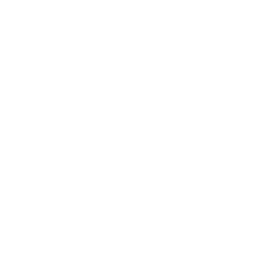

  4%|▎         | 36/1000 [16:33<7:12:51, 26.94s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 37 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_36_K_2_N_2_amortize_True.png


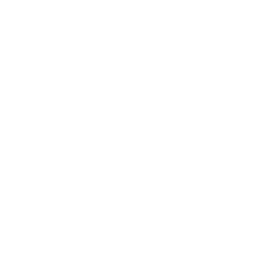

  4%|▎         | 37/1000 [17:00<7:11:52, 26.91s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 38 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_37_K_2_N_2_amortize_True.png


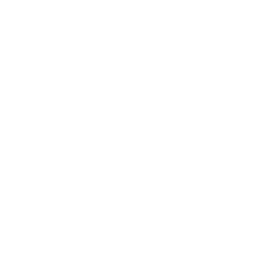

  4%|▍         | 38/1000 [17:27<7:11:09, 26.89s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 39 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_38_K_2_N_2_amortize_True.png


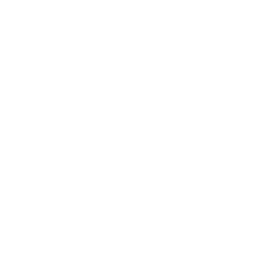

  4%|▍         | 39/1000 [17:54<7:10:35, 26.88s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 40 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_39_K_2_N_2_amortize_True.png


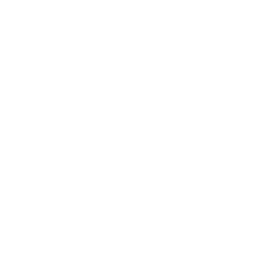

  4%|▍         | 40/1000 [18:21<7:11:12, 26.95s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 41 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_40_K_2_N_2_amortize_True.png


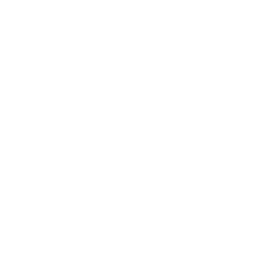

  4%|▍         | 41/1000 [18:48<7:10:20, 26.92s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 42 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_41_K_2_N_2_amortize_True.png


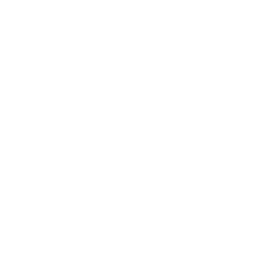

  4%|▍         | 42/1000 [19:15<7:10:52, 26.99s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 43 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_42_K_2_N_2_amortize_True.png


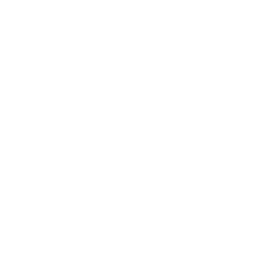

  4%|▍         | 43/1000 [19:42<7:09:44, 26.94s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 44 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_43_K_2_N_2_amortize_True.png


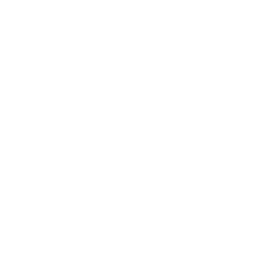

  4%|▍         | 44/1000 [20:09<7:08:45, 26.91s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 45 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_44_K_2_N_2_amortize_True.png


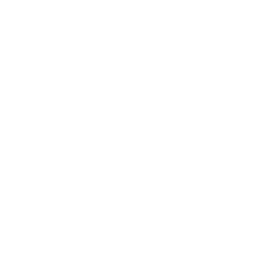

  4%|▍         | 45/1000 [20:36<7:07:57, 26.89s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 46 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_45_K_2_N_2_amortize_True.png


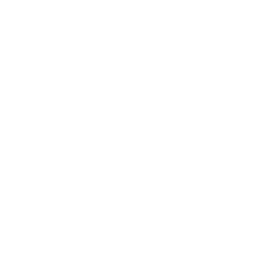

  5%|▍         | 46/1000 [21:02<7:07:18, 26.87s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 47 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_46_K_2_N_2_amortize_True.png


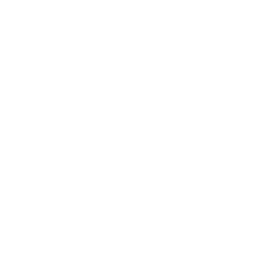

  5%|▍         | 47/1000 [21:29<7:06:44, 26.87s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 48 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_47_K_2_N_2_amortize_True.png


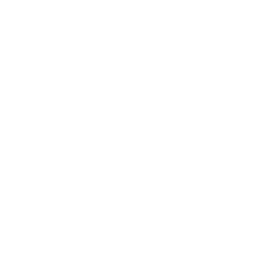

  5%|▍         | 48/1000 [21:56<7:06:19, 26.87s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 49 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_48_K_2_N_2_amortize_True.png


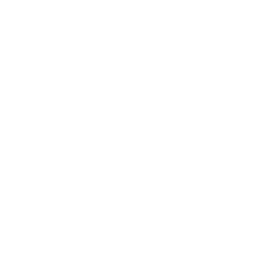

  5%|▍         | 49/1000 [22:23<7:05:47, 26.86s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 50 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_49_K_2_N_2_amortize_True.png


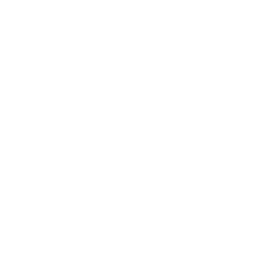

  5%|▌         | 50/1000 [22:50<7:05:15, 26.86s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 101/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
Current epoch: 51 	 Current ELBO: nan
Saved samples to ./pics/mnist_epoch_50_K_2_N_2_amortize_True.png


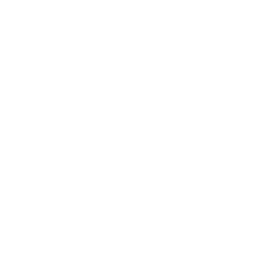

  5%|▌         | 51/1000 [23:17<7:04:44, 26.85s/it]

On batch number 1/118 and on k = 1 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5
On batch number 1/118 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.5


KeyboardInterrupt: 

In [8]:
print_info_ = 1

torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)


def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new, mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        p_old = args.std_normal.sample(mu.shape)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        dataset.train.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            # Accumulate alphas
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

        elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                            sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
    #     pdb.set_trace()
        (-grad_elbo).backward()
        if args.clip_norm:
            torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
        optimizer.step()
        optimizer.zero_grad()
        # Bias squared
    if ep % print_info_ == 0:
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print('a')

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Current epoch: 1 	 Current ELBO: -12.651106834411621
Mean abs mu0: 0.39614242
Mean sigma 0.8052846
Max sigma 1.1936707
Min sigma 0.63414264


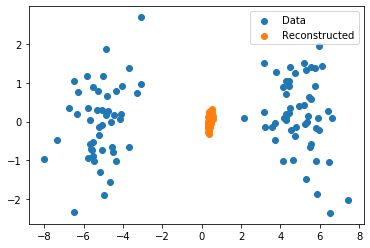

  1%|          | 10/1000 [00:04<07:12,  2.29it/s]

Current epoch: 11 	 Current ELBO: -5.435644626617432
Mean abs mu0: 0.4414808
Mean sigma 0.8532805
Max sigma 0.95218265
Min sigma 0.76852


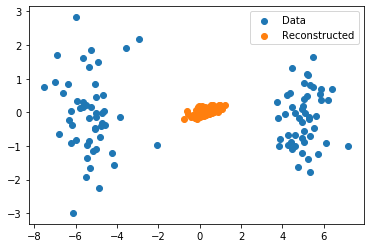

  2%|▏         | 20/1000 [00:08<07:04,  2.31it/s]

Current epoch: 21 	 Current ELBO: -4.653069496154785
Mean abs mu0: 0.94437736
Mean sigma 0.9820617
Max sigma 1.1874021
Min sigma 0.8822914


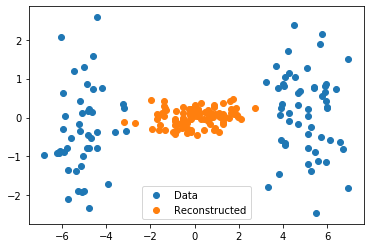

  3%|▎         | 30/1000 [00:13<06:52,  2.35it/s]

Current epoch: 31 	 Current ELBO: -4.465137481689453
Mean abs mu0: 0.94939834
Mean sigma 0.9194955
Max sigma 1.0309534
Min sigma 0.8351911


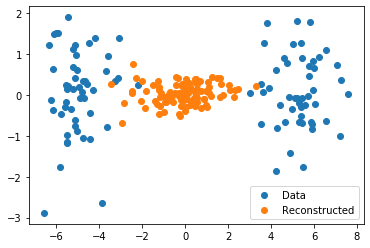

  4%|▍         | 40/1000 [00:17<06:48,  2.35it/s]

Current epoch: 41 	 Current ELBO: -4.450894832611084
Mean abs mu0: 0.9421467
Mean sigma 0.98574203
Max sigma 1.0572438
Min sigma 0.9231826


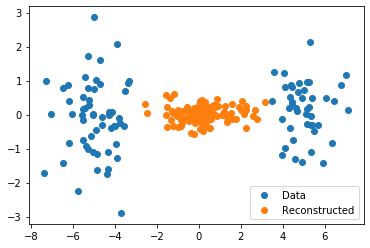

  5%|▌         | 50/1000 [00:21<06:44,  2.35it/s]

Current epoch: 51 	 Current ELBO: -4.44196891784668
Mean abs mu0: 0.884349
Mean sigma 0.9634834
Max sigma 0.99985874
Min sigma 0.89903647


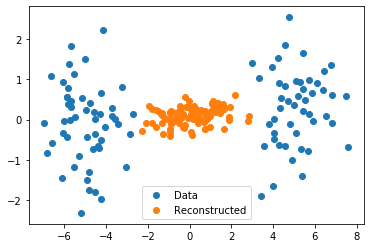

  6%|▌         | 60/1000 [00:26<06:40,  2.34it/s]

Current epoch: 61 	 Current ELBO: -4.5338897705078125
Mean abs mu0: 0.5939375
Mean sigma 0.99208695
Max sigma 1.0837096
Min sigma 0.9461533


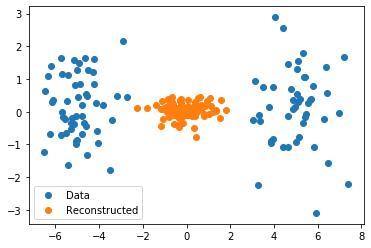

  7%|▋         | 70/1000 [00:30<06:36,  2.35it/s]

Current epoch: 71 	 Current ELBO: -4.358867168426514
Mean abs mu0: 0.5933838
Mean sigma 0.9663629
Max sigma 1.0048848
Min sigma 0.937383


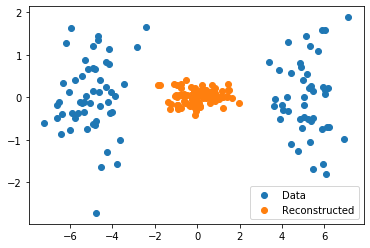

  8%|▊         | 80/1000 [00:34<06:32,  2.35it/s]

Current epoch: 81 	 Current ELBO: -4.461451530456543
Mean abs mu0: 0.38645706
Mean sigma 0.99292576
Max sigma 1.0505469
Min sigma 0.9479833


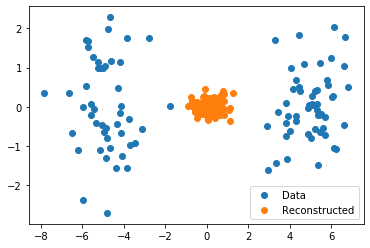

  9%|▉         | 90/1000 [00:39<06:35,  2.30it/s]

Current epoch: 91 	 Current ELBO: -4.495072841644287
Mean abs mu0: 0.43051276
Mean sigma 0.98703057
Max sigma 1.0867925
Min sigma 0.9341974


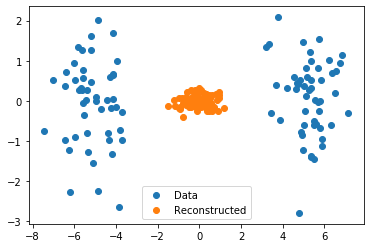

 10%|█         | 100/1000 [00:43<06:34,  2.28it/s]

Current epoch: 101 	 Current ELBO: -4.500545978546143
Mean abs mu0: 0.2986892
Mean sigma 0.9847636
Max sigma 1.0344812
Min sigma 0.94719565


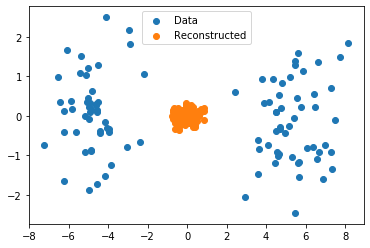

 11%|█         | 110/1000 [00:48<06:29,  2.29it/s]

Current epoch: 111 	 Current ELBO: -4.540060997009277
Mean abs mu0: 0.34184843
Mean sigma 0.9969566
Max sigma 1.058136
Min sigma 0.9478619


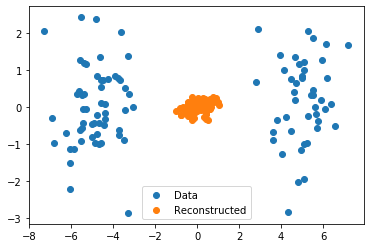

 12%|█▏        | 120/1000 [00:52<06:24,  2.29it/s]

Current epoch: 121 	 Current ELBO: -4.635712623596191
Mean abs mu0: 0.30237693
Mean sigma 0.97452027
Max sigma 1.0439012
Min sigma 0.9267528


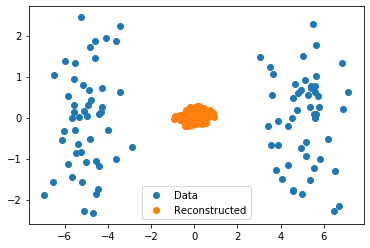

 13%|█▎        | 130/1000 [00:57<06:20,  2.29it/s]

Current epoch: 131 	 Current ELBO: -4.536761283874512
Mean abs mu0: 0.32558146
Mean sigma 1.0239944
Max sigma 1.0759747
Min sigma 1.0036936


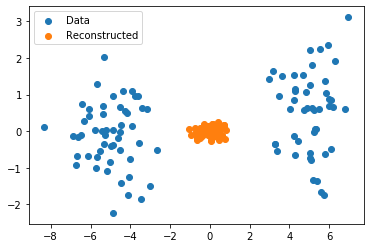

 14%|█▍        | 140/1000 [01:01<06:13,  2.30it/s]

Current epoch: 141 	 Current ELBO: -4.458585739135742
Mean abs mu0: 0.29819462
Mean sigma 1.017801
Max sigma 1.0995065
Min sigma 0.97938097


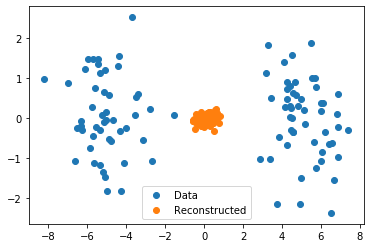

 15%|█▌        | 150/1000 [01:05<06:05,  2.32it/s]

Current epoch: 151 	 Current ELBO: -4.629887104034424
Mean abs mu0: 0.26218456
Mean sigma 0.9959036
Max sigma 1.0700939
Min sigma 0.9688362


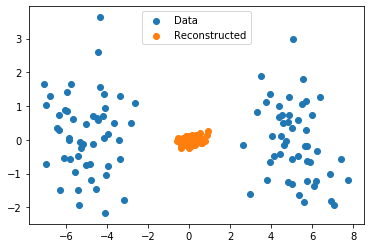

 16%|█▌        | 160/1000 [01:10<06:01,  2.33it/s]

Current epoch: 161 	 Current ELBO: -4.566075325012207
Mean abs mu0: 0.27191642
Mean sigma 0.97814155
Max sigma 1.0690175
Min sigma 0.9249239


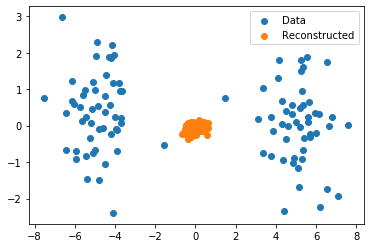

 17%|█▋        | 170/1000 [01:14<05:56,  2.33it/s]

Current epoch: 171 	 Current ELBO: -4.492166042327881
Mean abs mu0: 0.23764741
Mean sigma 0.9772421
Max sigma 1.0349576
Min sigma 0.93493223


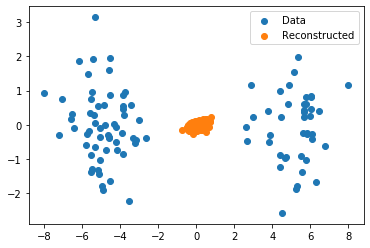

 18%|█▊        | 180/1000 [01:19<05:51,  2.33it/s]

Current epoch: 181 	 Current ELBO: -4.649998188018799
Mean abs mu0: 0.19665305
Mean sigma 0.9924004
Max sigma 1.0205994
Min sigma 0.97719395


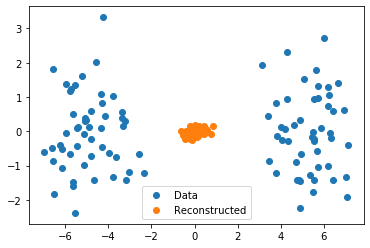

 19%|█▉        | 190/1000 [01:23<05:47,  2.33it/s]

Current epoch: 191 	 Current ELBO: -4.444227695465088
Mean abs mu0: 0.2038449
Mean sigma 1.0194833
Max sigma 1.0842533
Min sigma 0.98665166


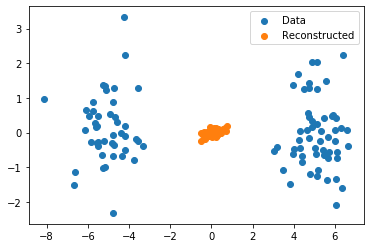

 20%|██        | 200/1000 [01:27<05:42,  2.33it/s]

Current epoch: 201 	 Current ELBO: -4.5238752365112305
Mean abs mu0: 0.24201196
Mean sigma 0.9910466
Max sigma 1.0368662
Min sigma 0.958246


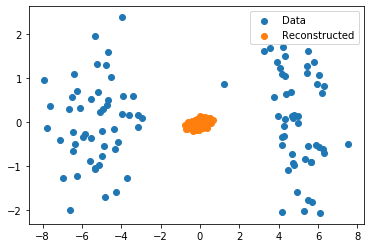

 21%|██        | 210/1000 [01:32<05:39,  2.33it/s]

Current epoch: 211 	 Current ELBO: -4.462403297424316
Mean abs mu0: 0.22804837
Mean sigma 0.9929878
Max sigma 1.0263294
Min sigma 0.9461212


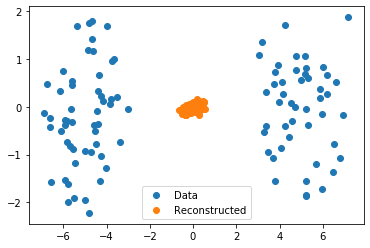

 22%|██▏       | 220/1000 [01:36<05:34,  2.33it/s]

Current epoch: 221 	 Current ELBO: -4.528268814086914
Mean abs mu0: 0.26860353
Mean sigma 0.99643844
Max sigma 1.0288768
Min sigma 0.97054255


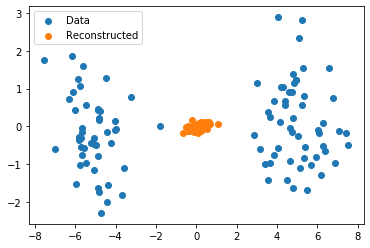

 23%|██▎       | 230/1000 [01:40<05:28,  2.34it/s]

Current epoch: 231 	 Current ELBO: -4.434115409851074
Mean abs mu0: 0.20930102
Mean sigma 1.0009435
Max sigma 1.0470958
Min sigma 0.95624626


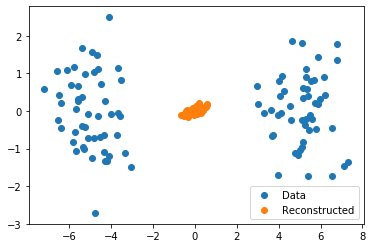

 24%|██▍       | 240/1000 [01:45<05:24,  2.34it/s]

Current epoch: 241 	 Current ELBO: -4.3742899894714355
Mean abs mu0: 0.21711744
Mean sigma 0.9952775
Max sigma 1.0376396
Min sigma 0.98013484


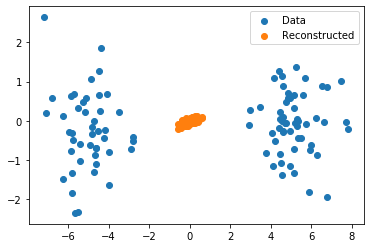

 25%|██▌       | 250/1000 [01:49<05:23,  2.32it/s]

Current epoch: 251 	 Current ELBO: -4.523660659790039
Mean abs mu0: 0.18561481
Mean sigma 0.9845727
Max sigma 1.0193199
Min sigma 0.96698415


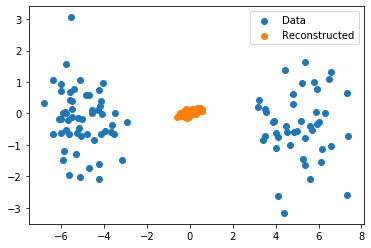

 26%|██▌       | 260/1000 [01:54<05:19,  2.31it/s]

Current epoch: 261 	 Current ELBO: -4.445756912231445
Mean abs mu0: 0.22225961
Mean sigma 0.9948085
Max sigma 1.0387286
Min sigma 0.97714233


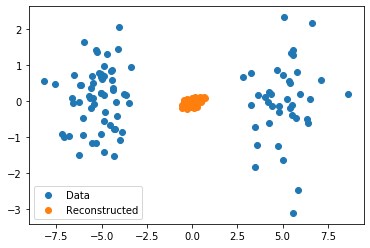

 27%|██▋       | 270/1000 [01:58<05:15,  2.32it/s]

Current epoch: 271 	 Current ELBO: -4.3822245597839355
Mean abs mu0: 0.19181946
Mean sigma 0.98120666
Max sigma 1.0100851
Min sigma 0.9503357


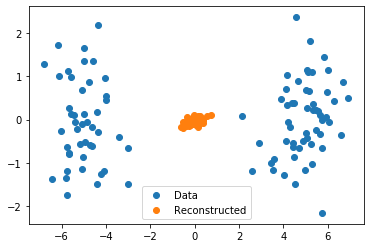

 28%|██▊       | 280/1000 [02:02<05:10,  2.32it/s]

Current epoch: 281 	 Current ELBO: -4.4813151359558105
Mean abs mu0: 0.18198866
Mean sigma 1.0089291
Max sigma 1.0331857
Min sigma 0.99885726


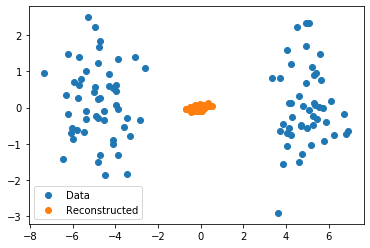

 29%|██▉       | 290/1000 [02:07<05:06,  2.32it/s]

Current epoch: 291 	 Current ELBO: -4.464707851409912
Mean abs mu0: 0.17602982
Mean sigma 1.0115863
Max sigma 1.0668628
Min sigma 0.9482607


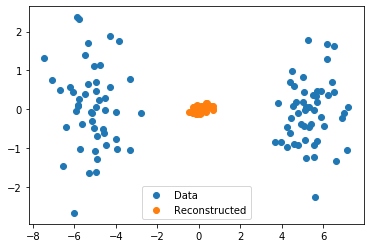

 30%|███       | 300/1000 [02:11<05:02,  2.32it/s]

Current epoch: 301 	 Current ELBO: -4.555074691772461
Mean abs mu0: 0.1936716
Mean sigma 0.99452484
Max sigma 1.0226912
Min sigma 0.95537555


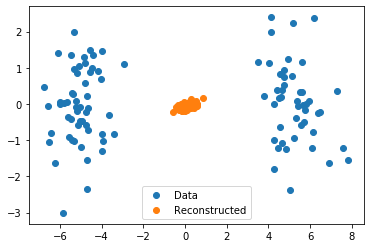

 31%|███       | 310/1000 [02:16<04:57,  2.32it/s]

Current epoch: 311 	 Current ELBO: -4.544419288635254
Mean abs mu0: 0.18559943
Mean sigma 1.0056105
Max sigma 1.0343953
Min sigma 0.98678434


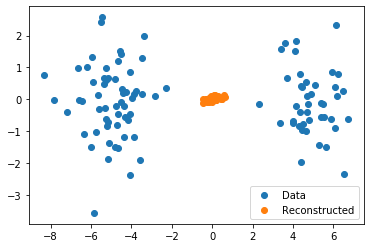

 32%|███▏      | 320/1000 [02:20<04:50,  2.34it/s]

Current epoch: 321 	 Current ELBO: -4.381446361541748
Mean abs mu0: 0.1743562
Mean sigma 0.99733603
Max sigma 1.0331407
Min sigma 0.98339176


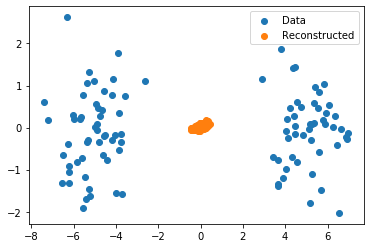

 33%|███▎      | 330/1000 [02:24<04:45,  2.35it/s]

Current epoch: 331 	 Current ELBO: -4.488588809967041
Mean abs mu0: 0.18565202
Mean sigma 1.0116532
Max sigma 1.0401208
Min sigma 1.0004605


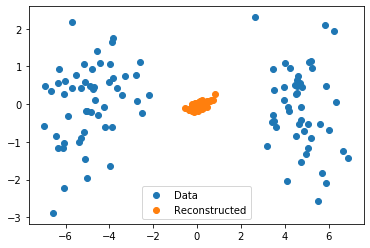

 34%|███▍      | 340/1000 [02:29<04:41,  2.35it/s]

Current epoch: 341 	 Current ELBO: -4.453038215637207
Mean abs mu0: 0.20086977
Mean sigma 1.0004582
Max sigma 1.0408624
Min sigma 0.9570874


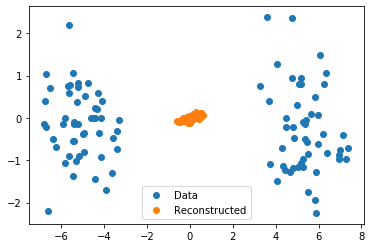

 35%|███▌      | 350/1000 [02:33<04:36,  2.35it/s]

Current epoch: 351 	 Current ELBO: -4.572504997253418
Mean abs mu0: 0.18790299
Mean sigma 1.0024301
Max sigma 1.0245295
Min sigma 0.9699553


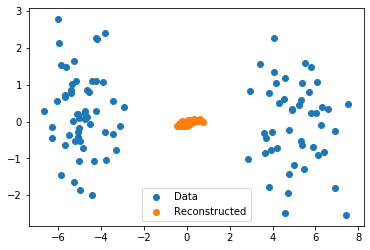

 36%|███▌      | 360/1000 [02:37<04:32,  2.35it/s]

Current epoch: 361 	 Current ELBO: -4.296996593475342
Mean abs mu0: 0.19062765
Mean sigma 0.99957764
Max sigma 1.0151993
Min sigma 0.983083


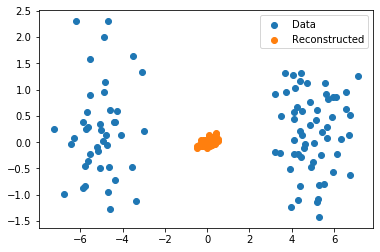

 37%|███▋      | 370/1000 [02:42<04:28,  2.35it/s]

Current epoch: 371 	 Current ELBO: -4.307260513305664
Mean abs mu0: 0.17624818
Mean sigma 1.0027156
Max sigma 1.0369612
Min sigma 0.9836166


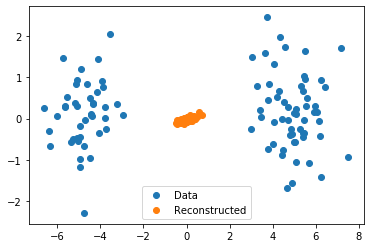

 38%|███▊      | 380/1000 [02:46<04:23,  2.35it/s]

Current epoch: 381 	 Current ELBO: -4.422294616699219
Mean abs mu0: 0.17790845
Mean sigma 1.0102583
Max sigma 1.0562603
Min sigma 0.970454


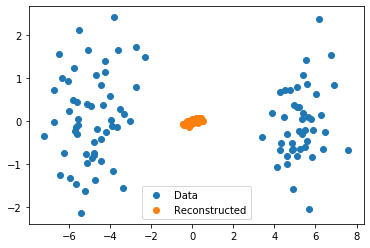

 39%|███▉      | 390/1000 [02:50<04:19,  2.35it/s]

Current epoch: 391 	 Current ELBO: -4.525256633758545
Mean abs mu0: 0.16861904
Mean sigma 0.9934205
Max sigma 1.0212467
Min sigma 0.9751922


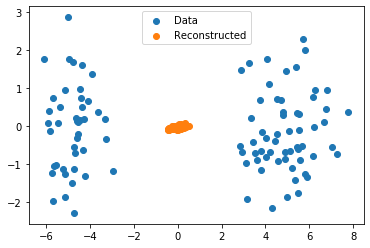

 40%|████      | 400/1000 [02:55<04:15,  2.35it/s]

Current epoch: 401 	 Current ELBO: -4.421323776245117
Mean abs mu0: 0.16576454
Mean sigma 0.99414074
Max sigma 1.0067015
Min sigma 0.97839475


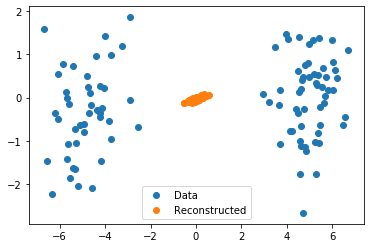

 41%|████      | 410/1000 [02:59<04:11,  2.35it/s]

Current epoch: 411 	 Current ELBO: -4.350273132324219
Mean abs mu0: 0.151844
Mean sigma 1.0002452
Max sigma 1.0286065
Min sigma 0.97528416


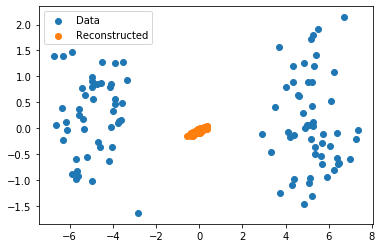

 42%|████▏     | 420/1000 [03:03<04:06,  2.35it/s]

Current epoch: 421 	 Current ELBO: -4.421353816986084
Mean abs mu0: 0.1729167
Mean sigma 0.99609405
Max sigma 1.0343266
Min sigma 0.9775878


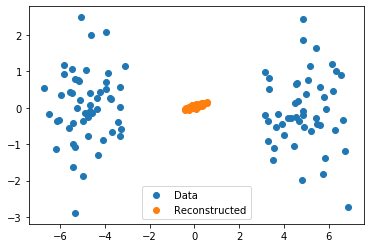

 43%|████▎     | 430/1000 [03:08<04:03,  2.34it/s]

Current epoch: 431 	 Current ELBO: -4.5356268882751465
Mean abs mu0: 0.15736069
Mean sigma 1.0003155
Max sigma 1.0232171
Min sigma 0.9872825


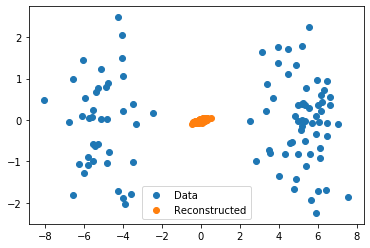

 44%|████▍     | 440/1000 [03:12<03:58,  2.35it/s]

Current epoch: 441 	 Current ELBO: -4.457740306854248
Mean abs mu0: 0.16961151
Mean sigma 0.98143005
Max sigma 1.0178921
Min sigma 0.9569558


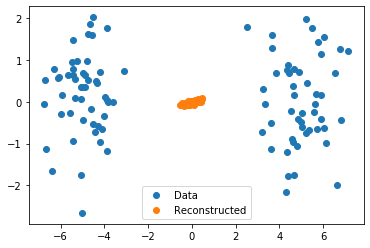

 45%|████▌     | 450/1000 [03:16<03:56,  2.33it/s]

Current epoch: 451 	 Current ELBO: -4.538450241088867
Mean abs mu0: 0.16467972
Mean sigma 0.9962575
Max sigma 1.0131567
Min sigma 0.9792522


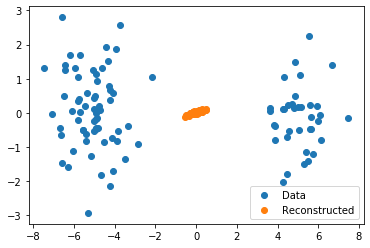

 46%|████▌     | 460/1000 [03:21<03:55,  2.29it/s]

Current epoch: 461 	 Current ELBO: -4.441637992858887
Mean abs mu0: 0.14985761
Mean sigma 0.9973707
Max sigma 1.0259691
Min sigma 0.9726041


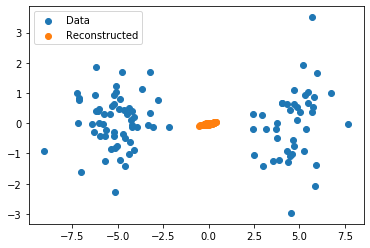

 47%|████▋     | 470/1000 [03:25<03:51,  2.29it/s]

Current epoch: 471 	 Current ELBO: -4.669460773468018
Mean abs mu0: 0.1484749
Mean sigma 0.9996071
Max sigma 1.0347538
Min sigma 0.9739029


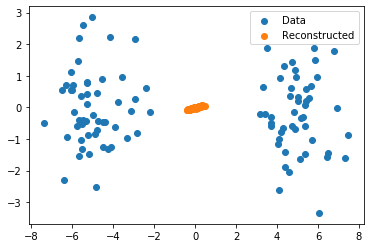

 48%|████▊     | 480/1000 [03:30<03:47,  2.29it/s]

Current epoch: 481 	 Current ELBO: -4.567652702331543
Mean abs mu0: 0.14254783
Mean sigma 0.9901106
Max sigma 1.0053519
Min sigma 0.9853753


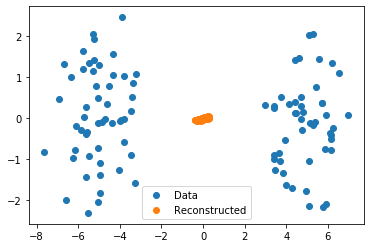

 49%|████▉     | 490/1000 [03:34<03:41,  2.30it/s]

Current epoch: 491 	 Current ELBO: -4.428730487823486
Mean abs mu0: 0.14053872
Mean sigma 1.0072776
Max sigma 1.0322605
Min sigma 0.9730021


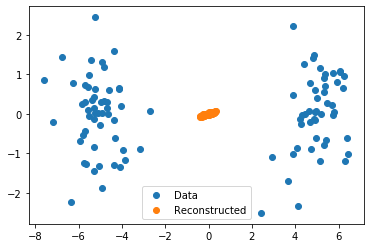

 50%|█████     | 500/1000 [03:39<03:36,  2.31it/s]

Current epoch: 501 	 Current ELBO: -4.600813388824463
Mean abs mu0: 0.13429499
Mean sigma 1.0114554
Max sigma 1.0406973
Min sigma 0.9946939


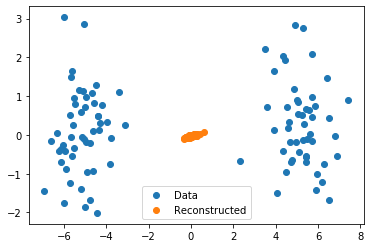

 51%|█████     | 510/1000 [03:43<03:33,  2.30it/s]

Current epoch: 511 	 Current ELBO: -4.455070495605469
Mean abs mu0: 0.123514764
Mean sigma 1.0027994
Max sigma 1.0269623
Min sigma 0.9964046


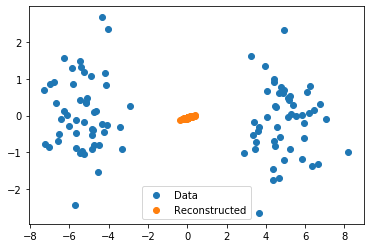

 52%|█████▏    | 520/1000 [03:47<03:29,  2.30it/s]

Current epoch: 521 	 Current ELBO: -4.5823516845703125
Mean abs mu0: 0.13661751
Mean sigma 0.98811215
Max sigma 1.0055461
Min sigma 0.9763936


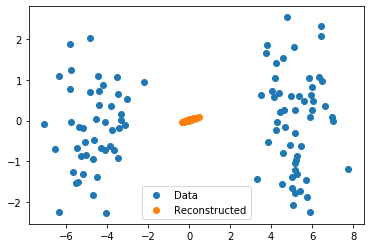

 53%|█████▎    | 530/1000 [03:52<03:25,  2.29it/s]

Current epoch: 531 	 Current ELBO: -4.32886266708374
Mean abs mu0: 0.13282084
Mean sigma 0.986022
Max sigma 1.0175438
Min sigma 0.9682239


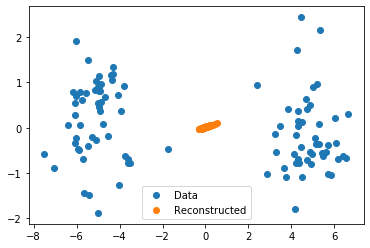

 54%|█████▍    | 540/1000 [03:56<03:20,  2.30it/s]

Current epoch: 541 	 Current ELBO: -4.481556415557861
Mean abs mu0: 0.115786225
Mean sigma 1.0018008
Max sigma 1.0347962
Min sigma 0.97042054


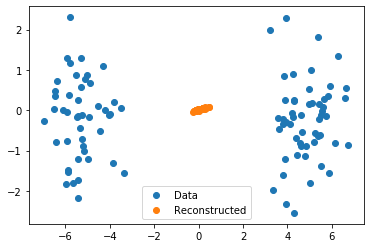

 55%|█████▌    | 550/1000 [04:01<03:14,  2.32it/s]

Current epoch: 551 	 Current ELBO: -4.542239665985107
Mean abs mu0: 0.10670696
Mean sigma 0.99337614
Max sigma 1.007679
Min sigma 0.98656046


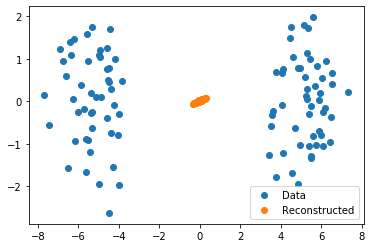

 56%|█████▌    | 560/1000 [04:05<03:09,  2.32it/s]

Current epoch: 561 	 Current ELBO: -4.560336589813232
Mean abs mu0: 0.10151102
Mean sigma 0.9918263
Max sigma 1.0097158
Min sigma 0.98016906


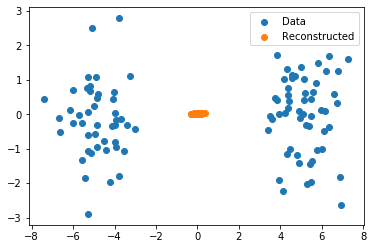

 57%|█████▋    | 570/1000 [04:10<03:05,  2.32it/s]

Current epoch: 571 	 Current ELBO: -4.411445617675781
Mean abs mu0: 0.0900882
Mean sigma 1.0003871
Max sigma 1.0209911
Min sigma 0.9795923


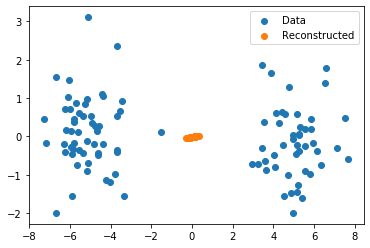

 58%|█████▊    | 580/1000 [04:14<03:01,  2.32it/s]

Current epoch: 581 	 Current ELBO: -4.40278434753418
Mean abs mu0: 0.09858993
Mean sigma 0.9978134
Max sigma 1.0130901
Min sigma 0.98533314


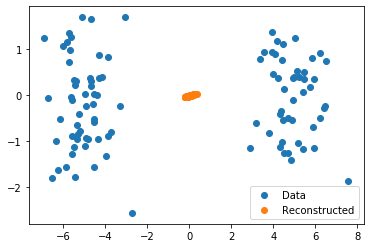

 59%|█████▉    | 590/1000 [04:18<02:57,  2.31it/s]

Current epoch: 591 	 Current ELBO: -4.4230804443359375
Mean abs mu0: 0.08997751
Mean sigma 0.9956439
Max sigma 1.0070883
Min sigma 0.98354846


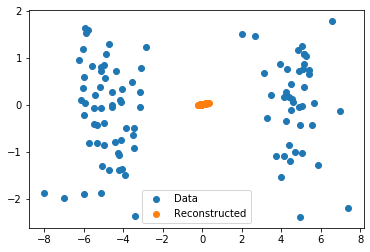

 60%|██████    | 600/1000 [04:23<02:53,  2.30it/s]

Current epoch: 601 	 Current ELBO: -4.449672698974609
Mean abs mu0: 0.08503449
Mean sigma 0.99734795
Max sigma 1.0297697
Min sigma 0.97588015


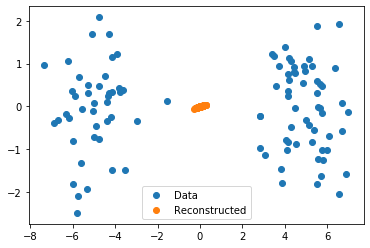

 61%|██████    | 610/1000 [04:27<02:50,  2.29it/s]

Current epoch: 611 	 Current ELBO: -4.410194396972656
Mean abs mu0: 0.09377483
Mean sigma 0.9976717
Max sigma 1.0104655
Min sigma 0.98166555


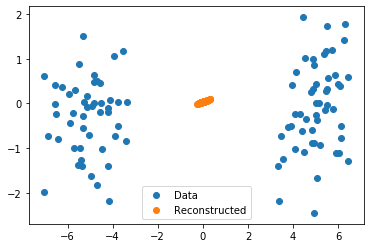

 62%|██████▏   | 620/1000 [04:32<02:43,  2.33it/s]

Current epoch: 621 	 Current ELBO: -4.399800777435303
Mean abs mu0: 0.081051536
Mean sigma 0.9935347
Max sigma 1.0170609
Min sigma 0.97171783


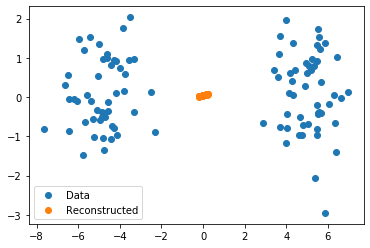

 63%|██████▎   | 630/1000 [04:36<02:40,  2.30it/s]

Current epoch: 631 	 Current ELBO: -4.434503555297852
Mean abs mu0: 0.08738322
Mean sigma 1.0046927
Max sigma 1.0236742
Min sigma 0.99086684


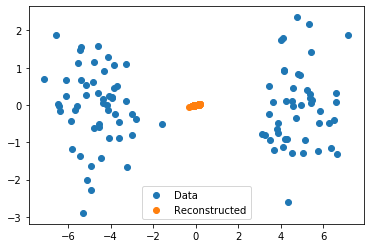

 64%|██████▍   | 640/1000 [04:41<02:36,  2.30it/s]

Current epoch: 641 	 Current ELBO: -4.466691017150879
Mean abs mu0: 0.10508501
Mean sigma 0.9902805
Max sigma 1.000745
Min sigma 0.9815085


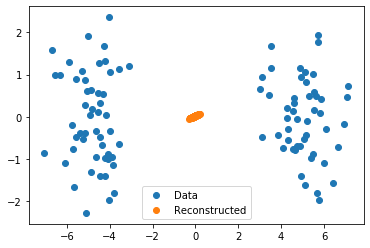

 65%|██████▌   | 650/1000 [04:45<02:32,  2.29it/s]

Current epoch: 651 	 Current ELBO: -4.537115573883057
Mean abs mu0: 0.07575875
Mean sigma 0.999753
Max sigma 1.012138
Min sigma 0.9916217


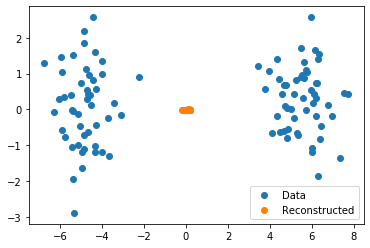

 66%|██████▌   | 660/1000 [04:49<02:27,  2.31it/s]

Current epoch: 661 	 Current ELBO: -4.392940044403076
Mean abs mu0: 0.08464971
Mean sigma 0.9963513
Max sigma 1.0153012
Min sigma 0.9771234


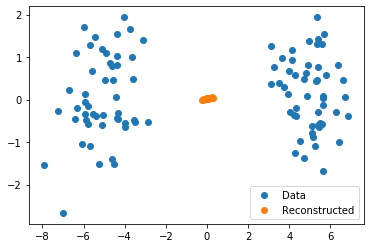

 67%|██████▋   | 670/1000 [04:54<02:22,  2.32it/s]

Current epoch: 671 	 Current ELBO: -4.4014763832092285
Mean abs mu0: 0.06964986
Mean sigma 0.98750836
Max sigma 1.0090148
Min sigma 0.97309494


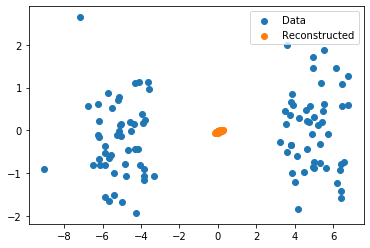

 68%|██████▊   | 680/1000 [04:58<02:17,  2.34it/s]

Current epoch: 681 	 Current ELBO: -4.450503826141357
Mean abs mu0: 0.08440628
Mean sigma 1.0059564
Max sigma 1.0221955
Min sigma 0.99848664


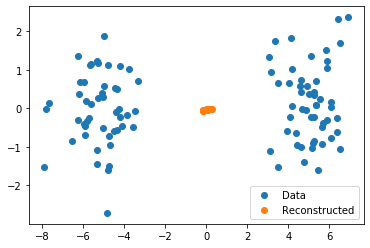

 69%|██████▉   | 690/1000 [05:03<02:12,  2.34it/s]

Current epoch: 691 	 Current ELBO: -4.359644889831543
Mean abs mu0: 0.07667899
Mean sigma 1.0131481
Max sigma 1.0280766
Min sigma 1.0014479


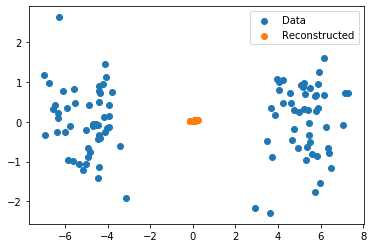

 70%|███████   | 700/1000 [05:07<02:09,  2.32it/s]

Current epoch: 701 	 Current ELBO: -4.527653217315674
Mean abs mu0: 0.069127776
Mean sigma 1.0019844
Max sigma 1.0177448
Min sigma 0.9907502


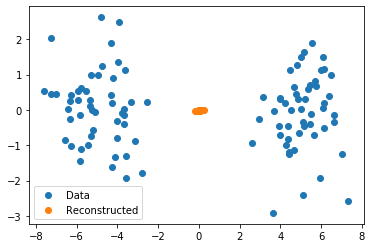

 71%|███████   | 710/1000 [05:11<02:06,  2.29it/s]

Current epoch: 711 	 Current ELBO: -4.437306880950928
Mean abs mu0: 0.06420267
Mean sigma 1.0044235
Max sigma 1.0162971
Min sigma 0.99873066


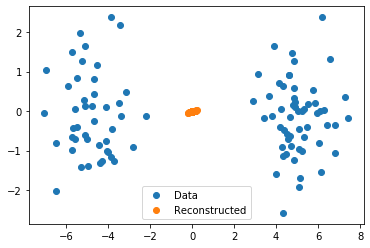

 72%|███████▏  | 720/1000 [05:16<02:02,  2.29it/s]

Current epoch: 721 	 Current ELBO: -4.465705394744873
Mean abs mu0: 0.06913249
Mean sigma 0.98995787
Max sigma 1.0041201
Min sigma 0.9797641


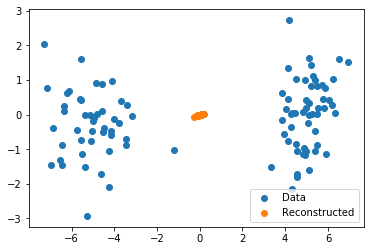

 73%|███████▎  | 730/1000 [05:20<01:58,  2.28it/s]

Current epoch: 731 	 Current ELBO: -4.388158321380615
Mean abs mu0: 0.07752073
Mean sigma 0.99753505
Max sigma 1.0212333
Min sigma 0.97308624


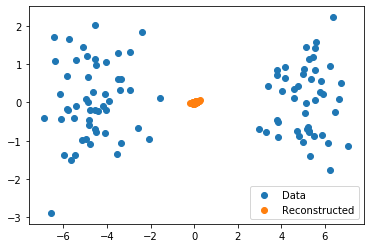

 74%|███████▍  | 740/1000 [05:25<01:53,  2.29it/s]

Current epoch: 741 	 Current ELBO: -4.519039630889893
Mean abs mu0: 0.053405028
Mean sigma 1.0158502
Max sigma 1.0462823
Min sigma 0.99402213


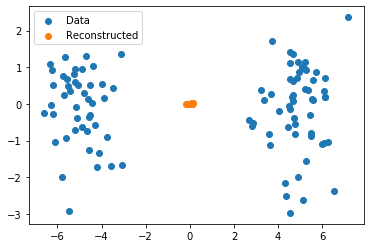

 75%|███████▌  | 750/1000 [05:29<01:47,  2.32it/s]

Current epoch: 751 	 Current ELBO: -4.398921012878418
Mean abs mu0: 0.06403142
Mean sigma 1.0036736
Max sigma 1.0129299
Min sigma 0.99247754


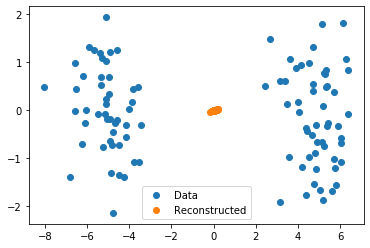

 76%|███████▌  | 760/1000 [05:34<01:43,  2.31it/s]

Current epoch: 761 	 Current ELBO: -4.3899993896484375
Mean abs mu0: 0.06538135
Mean sigma 1.0046508
Max sigma 1.0151684
Min sigma 0.99938834


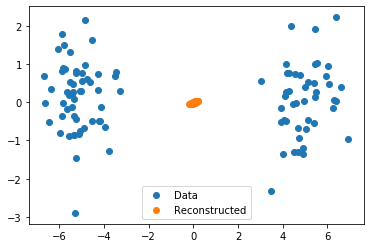

 77%|███████▋  | 770/1000 [05:38<01:39,  2.32it/s]

Current epoch: 771 	 Current ELBO: -4.3962602615356445
Mean abs mu0: 0.045975417
Mean sigma 0.99695057
Max sigma 1.0081304
Min sigma 0.9900272


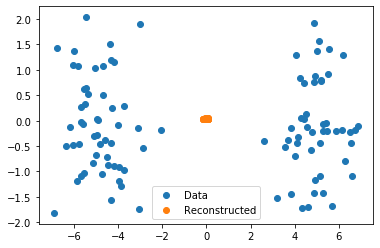

 78%|███████▊  | 780/1000 [05:42<01:35,  2.32it/s]

Current epoch: 781 	 Current ELBO: -4.295333385467529
Mean abs mu0: 0.051605914
Mean sigma 0.99232924
Max sigma 1.0162821
Min sigma 0.9691776


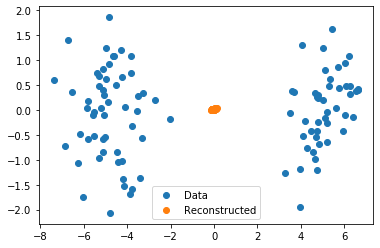

 79%|███████▉  | 790/1000 [05:47<01:31,  2.30it/s]

Current epoch: 791 	 Current ELBO: -4.545069694519043
Mean abs mu0: 0.05253591
Mean sigma 1.0019947
Max sigma 1.0115975
Min sigma 0.9978191


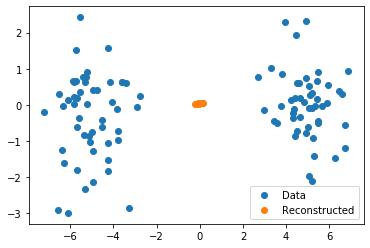

 80%|████████  | 800/1000 [05:51<01:26,  2.31it/s]

Current epoch: 801 	 Current ELBO: -4.393422603607178
Mean abs mu0: 0.05434949
Mean sigma 1.0132737
Max sigma 1.0310566
Min sigma 1.0023551


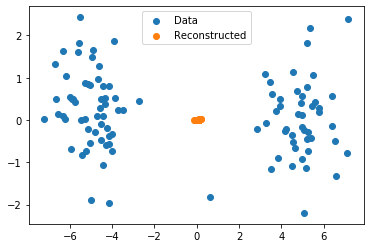

 81%|████████  | 810/1000 [05:56<01:22,  2.31it/s]

Current epoch: 811 	 Current ELBO: -4.519193172454834
Mean abs mu0: 0.0473798
Mean sigma 0.9931769
Max sigma 1.0092164
Min sigma 0.9762627


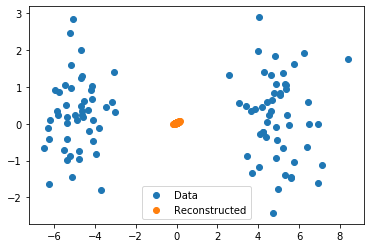

 82%|████████▏ | 820/1000 [06:00<01:18,  2.31it/s]

Current epoch: 821 	 Current ELBO: -4.478633403778076
Mean abs mu0: 0.049457207
Mean sigma 1.0038074
Max sigma 1.0183947
Min sigma 0.98881555


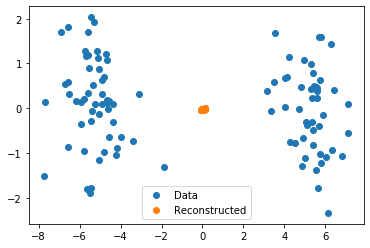

 83%|████████▎ | 830/1000 [06:04<01:13,  2.31it/s]

Current epoch: 831 	 Current ELBO: -4.454380989074707
Mean abs mu0: 0.038717423
Mean sigma 0.9938835
Max sigma 1.0188471
Min sigma 0.97199714


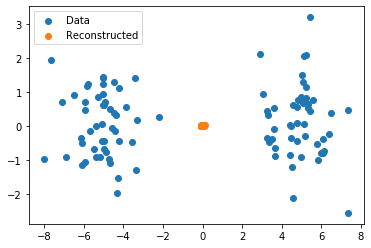

 84%|████████▍ | 840/1000 [06:09<01:09,  2.31it/s]

Current epoch: 841 	 Current ELBO: -4.523026466369629
Mean abs mu0: 0.048679996
Mean sigma 0.98801297
Max sigma 1.0092659
Min sigma 0.9687108


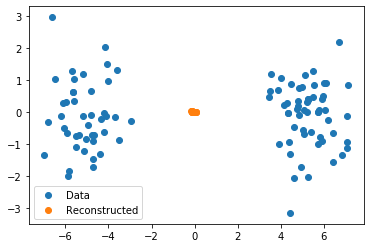

 85%|████████▌ | 850/1000 [06:13<01:04,  2.31it/s]

Current epoch: 851 	 Current ELBO: -4.3486175537109375
Mean abs mu0: 0.057427954
Mean sigma 1.0035865
Max sigma 1.0102153
Min sigma 0.995174


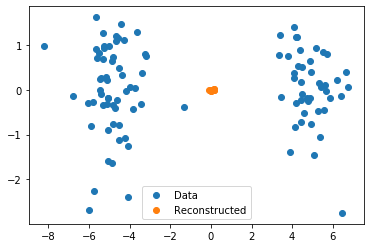

 86%|████████▌ | 860/1000 [06:18<01:00,  2.30it/s]

Current epoch: 861 	 Current ELBO: -4.408691883087158
Mean abs mu0: 0.03745976
Mean sigma 1.0148257
Max sigma 1.025903
Min sigma 1.0028194


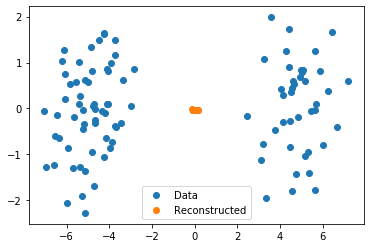

 87%|████████▋ | 870/1000 [06:22<00:55,  2.34it/s]

Current epoch: 871 	 Current ELBO: -4.4827094078063965
Mean abs mu0: 0.029104093
Mean sigma 0.99954987
Max sigma 1.0063934
Min sigma 0.9947736


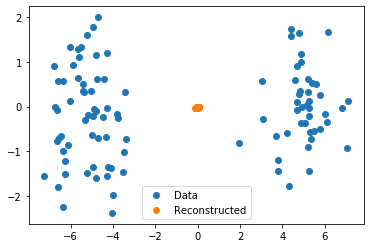

 88%|████████▊ | 880/1000 [06:26<00:51,  2.34it/s]

Current epoch: 881 	 Current ELBO: -4.6211066246032715
Mean abs mu0: 0.032066435
Mean sigma 0.99769497
Max sigma 1.0177007
Min sigma 0.9832995


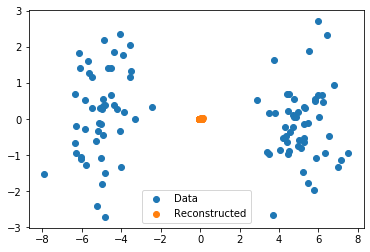

 89%|████████▉ | 890/1000 [06:31<00:47,  2.33it/s]

Current epoch: 891 	 Current ELBO: -4.4835991859436035
Mean abs mu0: 0.030636108
Mean sigma 0.9965443
Max sigma 1.0088241
Min sigma 0.9896475


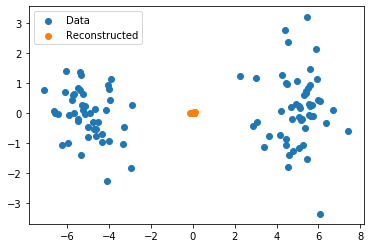

 90%|█████████ | 900/1000 [06:35<00:43,  2.33it/s]

Current epoch: 901 	 Current ELBO: -4.611424922943115
Mean abs mu0: 0.051183537
Mean sigma 1.0064795
Max sigma 1.023626
Min sigma 0.9925126


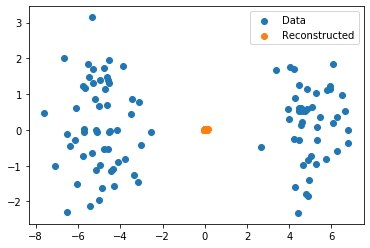

 91%|█████████ | 910/1000 [06:40<00:38,  2.33it/s]

Current epoch: 911 	 Current ELBO: -4.359862327575684
Mean abs mu0: 0.040333632
Mean sigma 0.99884224
Max sigma 1.0091145
Min sigma 0.9898958


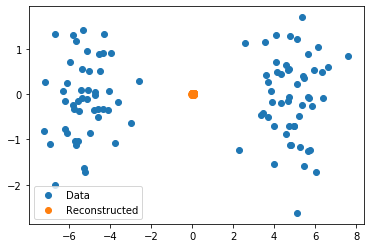

 92%|█████████▏| 920/1000 [06:44<00:34,  2.33it/s]

Current epoch: 921 	 Current ELBO: -4.407416343688965
Mean abs mu0: 0.026897715
Mean sigma 1.0039673
Max sigma 1.0102859
Min sigma 0.99803543


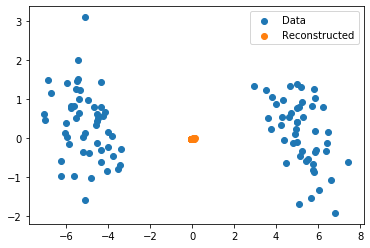

 93%|█████████▎| 930/1000 [06:48<00:29,  2.34it/s]

Current epoch: 931 	 Current ELBO: -4.515214443206787
Mean abs mu0: 0.030965274
Mean sigma 0.9965085
Max sigma 1.0096118
Min sigma 0.9854162


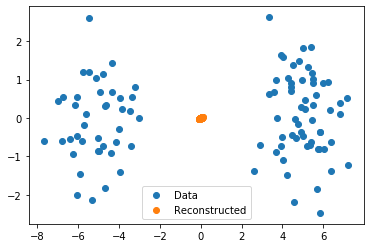

 94%|█████████▍| 940/1000 [06:53<00:25,  2.34it/s]

Current epoch: 941 	 Current ELBO: -4.489949703216553
Mean abs mu0: 0.023740133
Mean sigma 1.0040339
Max sigma 1.0149443
Min sigma 0.9907467


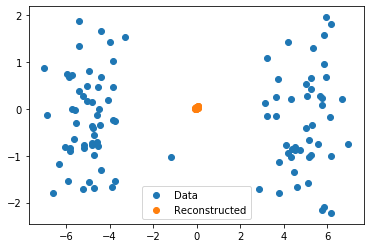

 95%|█████████▌| 950/1000 [06:57<00:21,  2.34it/s]

Current epoch: 951 	 Current ELBO: -4.550689220428467
Mean abs mu0: 0.024052229
Mean sigma 1.0044084
Max sigma 1.0138783
Min sigma 0.9956517


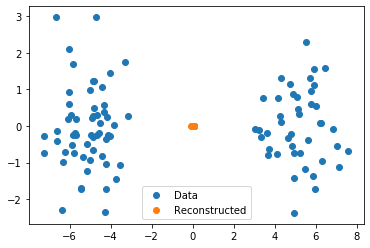

 96%|█████████▌| 960/1000 [07:01<00:17,  2.34it/s]

Current epoch: 961 	 Current ELBO: -4.562448024749756
Mean abs mu0: 0.07156718
Mean sigma 0.9868848
Max sigma 0.9897847
Min sigma 0.98367786


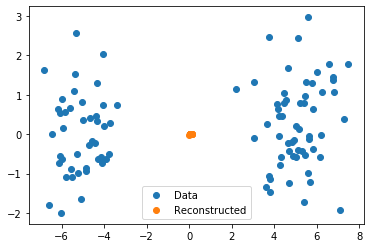

 97%|█████████▋| 970/1000 [07:06<00:12,  2.34it/s]

Current epoch: 971 	 Current ELBO: -4.453022480010986
Mean abs mu0: 0.020083483
Mean sigma 1.0050633
Max sigma 1.0112678
Min sigma 0.9985928


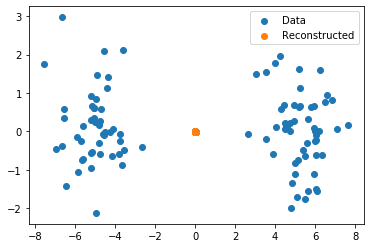

 98%|█████████▊| 980/1000 [07:10<00:08,  2.37it/s]

Current epoch: 981 	 Current ELBO: -4.377506256103516
Mean abs mu0: 0.028587818
Mean sigma 1.0002307
Max sigma 1.0109409
Min sigma 0.99194497


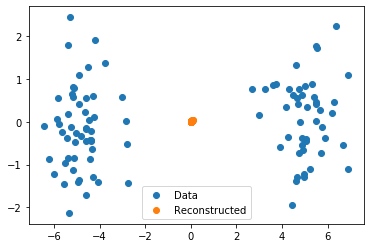

 99%|█████████▉| 990/1000 [07:14<00:04,  2.38it/s]

Current epoch: 991 	 Current ELBO: -4.411505222320557
Mean abs mu0: 0.025954345
Mean sigma 1.0049244
Max sigma 1.0155953
Min sigma 0.99551153


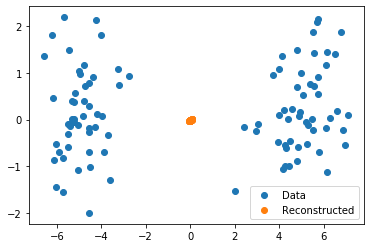

100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


In [8]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)